# **Abnormal Transaction Detection(비정상 거래 탐지)**

## Project Outline


> ### 수행 기간 : *23.04.17 ~ 23.04.30*

> ### 활용 데이터셋 : *card_transaction_data.csv(1852394 * 22 features, 1 binary target)*
    데이터 사이언스 커뮤니티의 오픈 데이터를 통해 본 작업을 수행했습니다.
    2019.01 ~ 2020.12월까지 약 2년 간의 카드 거래내역 데이터를 담고 있습니다.  
    거래 시간, 거래 금액, 고객 정보, 이상 거래 여부(target) 등의 변수가 포함돼 있습니다.

> ### 사용 모델 : *LightGBM*

> ### 모델 최종 성능 : *AUC 0.995*

> ### 작업 환경 : *Google Colab*

## 작업 세팅

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import warnings
warnings.filterwarnings('ignore')

import geopy.distance
# 위도 / 경도 feature engineering

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
# 모델링(LightGBM)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
# 평가지표

## 데이터 불러오기

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/card_transaction_data.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [ ]:
# 불필요 컬럼 제거(Unnamed: 0)
df.drop('Unnamed: 0', axis= 1, inplace= True)
df.info(show_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

trans_date_trans_time : 거래 시간

cc_num : 카드 번호

merchant : 거래 상점

category : 거래 상점의 범주  

amt : 거래 금액

first / last : 고객 이름

gender : 고객 성별

street / city / state / zip : 고객 거주지 정보  

lat / long : 고객 거주지에 대한 위도 / 경도  

city_pop : 고객 우편번호(zip) 에 속하는 인구 수  

job : 고객 직업  

dob : 고객 생년월일

trans_num : 거래 번호  

unix_time : 거래 시간  

merch_lat / merch_long : 상점 위치에 대한 위도 / 경도  

**is_fraud : 사기 거래 여부(타겟)**

In [ ]:
round(df.describe(), 2)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


* max(amt) / max(city_pop) : 평균에 비해 급격하게 높은 값이므로, 아웃라이어가 의심됩니다.
* mean(is_fraud)= 0.01 : 이상 거래 비율이 매우 낮은 imbalanced data 라고 할 수 있습니다.

In [ ]:
# 이상 거래 탐지 모델링에 불필요하다고 판단되는 feature 제거
df.drop(['first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time', 'job', 'merchant'], axis= 1, inplace= True)

In [ ]:
# datetime 자료형으로 변환
df['trans_date_trans_time']= pd.to_datetime(df['trans_date_trans_time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   category               object        
 3   amt                    float64       
 4   gender                 object        
 5   lat                    float64       
 6   long                   float64       
 7   city_pop               int64         
 8   dob                    object        
 9   merch_lat              float64       
 10  merch_long             float64       
 11  is_fraud               int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 169.6+ MB


## Feature Engineering

### 결제 금액(amt)

In [ ]:
# Z-score 활용(평소 소비 패턴과 비교를 위한 척도), cc_num(카드 번호) 별 amt 평균 / 표준 편차
amt_info= df.groupby('cc_num').agg(['mean', 'std'])['amt'].reset_index()
amt_info.head()

,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660


In [ ]:
# 기존 데이터셋과 카드 번호 기준 병합
df= df.merge(amt_info, on= 'cc_num', how= 'left')

In [ ]:
# Z-score 계산
df['amt_z_score']= (df['amt']- df['mean'])/ df['std']

In [ ]:
df[['amt', 'mean', 'std', 'amt_z_score']].head()

,amt,mean,std,amt_z_score
0,4.97,89.408743,127.530101,-0.662108
1,107.23,56.078113,159.201852,0.321302
2,220.11,69.924272,116.688602,1.287064
3,45.00,80.090040,280.077880,-0.125287
4,41.96,95.341146,94.322842,-0.565941


In [ ]:
# 불필요 컬럼 제거(Z-score 구했으므로)
df.drop(['mean', 'std'], axis= 1, inplace= True)

### 거래 상점의 범주(category)

In [ ]:
# 각 개인마다 어떤 상점 범주에서 얼마만큼의 금액을 쓰는지,
category_info= df.groupby(['cc_num', 'category']).agg(['mean', 'std'])['amt'].reset_index()

In [ ]:
# 병합
df= df.merge(category_info, on= ['cc_num', 'category'], how= 'left')

In [ ]:
# Z-score 계산 후, 불필요 컬럼 제거
df['cat_z_score']= (df['amt']- df['mean'])/ df['std']
df.drop(['mean', 'std'], axis= 1, inplace= True)

### 거리(geopy 라이브러리 활용)

In [ ]:
# 고객 위치/ 상점 위치 사이 거리 비교, Z-score 활용한 이상 패턴 탐지

df['merch_coord']= pd.Series(zip(df['merch_lat'], df['merch_long']))
# 상점 위치의 위도/ 경도

df['cust_coord']= pd.Series(zip(df['lat'], df['long']))
# 고객 거주지 위도/ 경도

In [ ]:
# 'distance' 변수 추가
df['distance']= df.apply(lambda x: geopy.distance.distance(x['merch_coord'], x['cust_coord']).km, axis= 1)

In [ ]:
distance_info= df.groupby('cc_num').agg(['mean', 'std'])['distance'].reset_index()
df= df.merge(distance_info, on= 'cc_num', how= 'left')
df['distance_z_score']= (df['distance']- df['mean'])/ df['std']
df.drop(['mean', 'std'], axis= 1, inplace= True)
df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,merch_coord,cust_coord,distance,distance_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297,"(36.011293, -82.048315)","(36.0788, -81.1781)",78.773821,0.030974
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,"(49.159047, -118.186462)","(48.8878, -118.2105)",30.216618,-1.475224
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,2.872509,"(43.150704, -112.154481)","(42.1808, -112.262)",108.102912,1.160572
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,-1.050197,"(47.034331, -112.561071)","(46.2306, -112.1138)",95.685115,0.818063
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,1.312866,"(38.674999, -78.632459)","(38.4207, -79.4629)",77.702395,0.064037


### etc.

In [ ]:
# 2023 년 기준 계산된 '나이' feature 생성
df['age']= 2023- pd.to_datetime(df['dob']).dt.year

In [ ]:
# 피쳐 엔지니어링에 사용한 컬럼 제거
df.drop(['cc_num', 'lat', 'long', 'merch_lat', 'merch_long', 'dob', 'merch_coord', 'cust_coord'], axis= 1, inplace= True)

In [ ]:
# 거래 상점의 범주 / 고객 성별을 더미 변수 처리
df= pd.get_dummies(df, columns= ['category', 'gender'], drop_first= True)

In [ ]:
# 거래 시간(trans_date_trans_time) 인덱스 설정
df.set_index('trans_date_trans_time', inplace= True)
df.head()

,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,35,0,0,...,0,0,0,1,0,0,0,0,0,0
2019-01-01 00:00:44,107.23,149,0,0.321302,0.317631,30.216618,-1.475224,45,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 00:00:51,220.11,4154,0,1.287064,2.872509,108.102912,1.160572,61,0,0,...,0,0,0,0,0,0,0,0,0,1
2019-01-01 00:01:16,45.00,1939,0,-0.125287,-1.050197,95.685115,0.818063,56,0,1,...,0,0,0,0,0,0,0,0,0,1
2019-01-01 00:03:06,41.96,99,0,-0.565941,1.312866,77.702395,0.064037,37,0,0,...,0,0,0,0,1,0,0,0,0,1


## Modeling

### version_1

In [ ]:
# 비정상 거래 모델링을 위해 '특정 날짜' 기준 이전 데이터로 모델 학습, 이후 데이터는 테스트 데이터 활용
# 2020.07월 기준
train= df[df.index < '2020-07-01'] # 훈련 데이터셋
test= df[df.index >= '2020-07-01'] # 테스트 데이터셋

In [ ]:
len(test)/ len(df) # 테스트 데이터셋 비율

0.2837738623640543

In [ ]:
# 타겟 변수 분리
X_train= train.drop('is_fraud', axis= 1)
X_test= test.drop('is_fraud', axis= 1)
y_train= train['is_fraud']
y_test= test['is_fraud']

In [ ]:
md1= lgb.LGBMClassifier(random_state= 100)
md1.fit(X_train, y_train)
pred1= md1.predict(X_test)

In [ ]:
# 정확도 확인
accuracy_score(y_test, pred1)

0.9970741599624092

**Imbalanced data 이므로 높은 예측률이 의미가 없음.**

In [ ]:
print(confusion_matrix(y_test, pred1))

[[522932    717]
 [   821   1191]]


**821건의 비정상 거래를 잡아내지 못함(2종 오류).**  

**717건의 거래를 비정상 거래로 잘못 예측(1종 오류).**

In [ ]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.62      0.59      0.61      2012

    accuracy                           1.00    525661
   macro avg       0.81      0.80      0.80    525661
weighted avg       1.00      1.00      1.00    525661



**모델링 시, 실제 비정상 거래를 얼마나 많이 예측해냈는지를 의미하는 재현율이 중요(recall, 0.59).**

In [ ]:
# 1(비정상 거래 binary) 예측 확률만 슬라이싱
proba1= md1.predict_proba(X_test)
proba1= proba1[:, 1]

In [ ]:
# 비정상 거래 확률에 더 예민하게 반응
proba_int1= (proba1 > 0.2).astype('int')

# 보다 둔감하게 반응
proba_int2= (proba1 > 0.8).astype('int')

In [ ]:
# 예민
print(classification_report(y_test, proba_int1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.48      0.70      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.74      0.85      0.78    525661
weighted avg       1.00      1.00      1.00    525661



**재현율이 어느 정도 개선되었지만, 정확도(precision) 이 너무 낮음.**

In [ ]:
# 둔감
print(classification_report(y_test, proba_int2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.69      0.52      0.60      2012

    accuracy                           1.00    525661
   macro avg       0.85      0.76      0.80    525661
weighted avg       1.00      1.00      1.00    525661



In [ ]:
# roc_auc_score
roc_auc_score(y_test, proba1)

0.9366006092163013

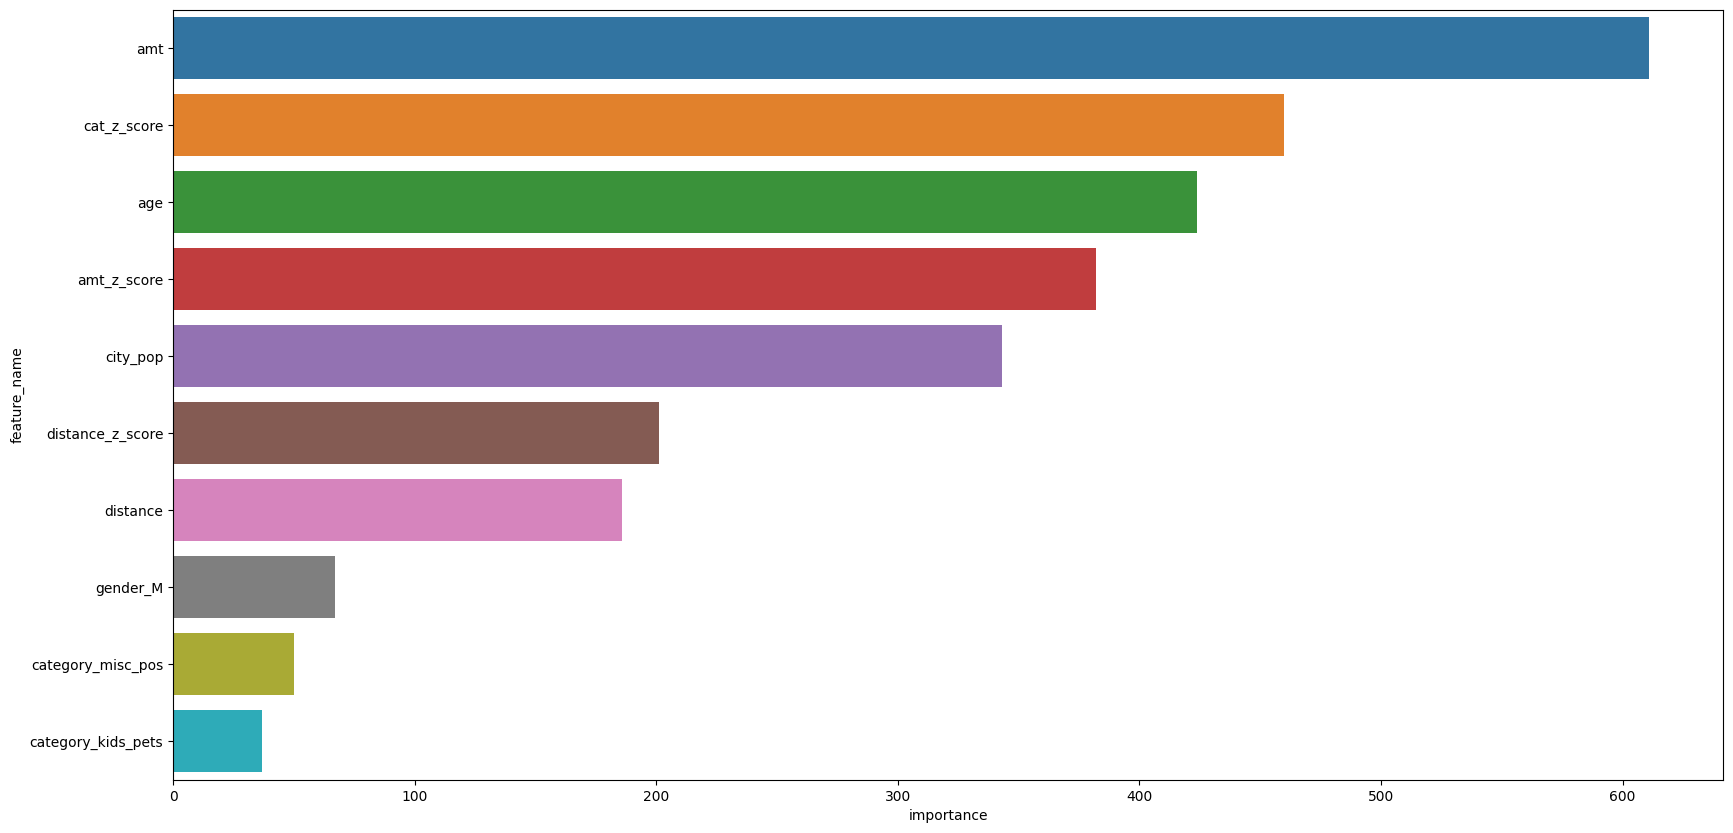

In [ ]:
# 모델 version_1 영향을 주는 feature 중요도

feature_imp= pd.DataFrame({'feature_name': X_train.columns, 'importance': md1.feature_importances_}).\
sort_values('importance', ascending= False)

plt.figure(figsize= (20, 10))
sns.barplot(x= 'importance', y= 'feature_name', data= feature_imp.head(10))
plt.show()

### version_2(Champion Model)

#### 튜닝

In [ ]:
# 랜덤 그리드 서치
params= {
    'n_estimators': [100, 500, 1000], # 모델 학습 반복 횟수
    'learning_rate': [0.01, 0.05, 0.1, 0.3], # 학습률
    'lambda_l1': [0, 10, 20, 30, 50], # L1 정규화
    'lambda_l2': [0, 10, 20, 30, 50], # L2 정규화
    'max_depth': [5, 10, 15, 20], # 최대 깊이
    'subsample': [0.6, 0.8, 1] # 부스트 트리에 사용될 샘플 비율
}

In [ ]:
# 랜덤 그리드 서치 객체 생성
md2= lgb.LGBMClassifier(random_state= 100)
rs= RandomizedSearchCV(md2, param_distributions= params, n_iter= 30, scoring= 'roc_auc', random_state= 100, n_jobs= -1)

In [ ]:
start= time.time()
rs.fit(X_train, y_train) # 학습
print(time.time()- start) # 총 소요 시간 확인

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
5097.981829166412


**약 85분 소요.**

In [ ]:
# 최적 하이퍼 파라미터 확인
rs.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0}

In [ ]:
# AUC 확인
rs_proba= rs.predict_proba(X_test)
roc_auc_score(y_test, rs_proba[:, 1])

0.9953122884656392

**튜닝 전 AUC(0.9366) -> 튜닝 후 AUC(0.995)**

In [ ]:
# 비정상 거래 확률에 더 예민하게 반응하게끔 설정(0.2 확률 초과는 비정상 거래 처리)
rs_proba_int= (rs_proba[:, 1] > 0.2).astype('int')
print(confusion_matrix(y_test, rs_proba_int))

[[522519   1130]
 [   504   1508]]


In [ ]:
print(classification_report(y_test, rs_proba_int))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.57      0.75      0.65      2012

    accuracy                           1.00    525661
   macro avg       0.79      0.87      0.82    525661
weighted avg       1.00      1.00      1.00    525661



**현재까지 가장 높은 f1-score 기록(0.65).**

### version_3

**LightGBM.train() 활용**

* train set : 2019.01 ~ 2019.12

* validation set : 2020.01 ~ 2020.06

* test set : 2020.07 ~ 2020.12

In [ ]:
train= df[df.index < '2020-01-01']
val= df[(df.index >= '2020-01-01') & (df.index < '2020-07-01')]
test= df[df.index >= '2020-07-01']

In [ ]:
# 독립 / 종속(타겟) 변수 분리

X_train= train.drop('is_fraud', axis= 1)
X_val= val.drop('is_fraud', axis= 1)
X_test= test.drop('is_fraud', axis= 1)

y_train= train['is_fraud']
y_val= val['is_fraud']
y_test= test['is_fraud']

In [ ]:
# LightGBM 호환 데이터셋으로 변환(훈련 / 검증 데이터)

d_train= lgb.Dataset(X_train, label= y_train)
d_val= lgb.Dataset(X_val, label= y_val)

In [ ]:
params_set= rs.best_params_ # 최적 파라미터 설정
params_set['metrics']= 'auc' # 평가 기준 추가

In [ ]:
params_set

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

In [ ]:
# version_3 모델링
md3= lgb.train(params_set, d_train, valid_sets= [d_val], early_stopping_rounds= 100, verbose_eval= 100)

# early_stopping_rounds : 불필요 학습 시간 제한
# verbose_eval : 결과물을 특정 간격으로 출력(n_estimators= 1000 개 설정돼 있으므로)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.005644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.97237
[200]	valid_0's auc: 0.988574
[300]	valid_0's auc: 0.993031
[400]	valid_0's auc: 0.992582
Early stopping, bes

**Early stopping, best iteration is:**  
**[327]	valid_0's auc: 0.993459**

In [ ]:
# 예측
pred3= md3.predict(X_test)

In [ ]:
# 모델 성능 확인
roc_auc_score(y_test, pred3)

0.991352108964131

**버전2 AUC(0.995) > 버전3 AUC(0.991)**

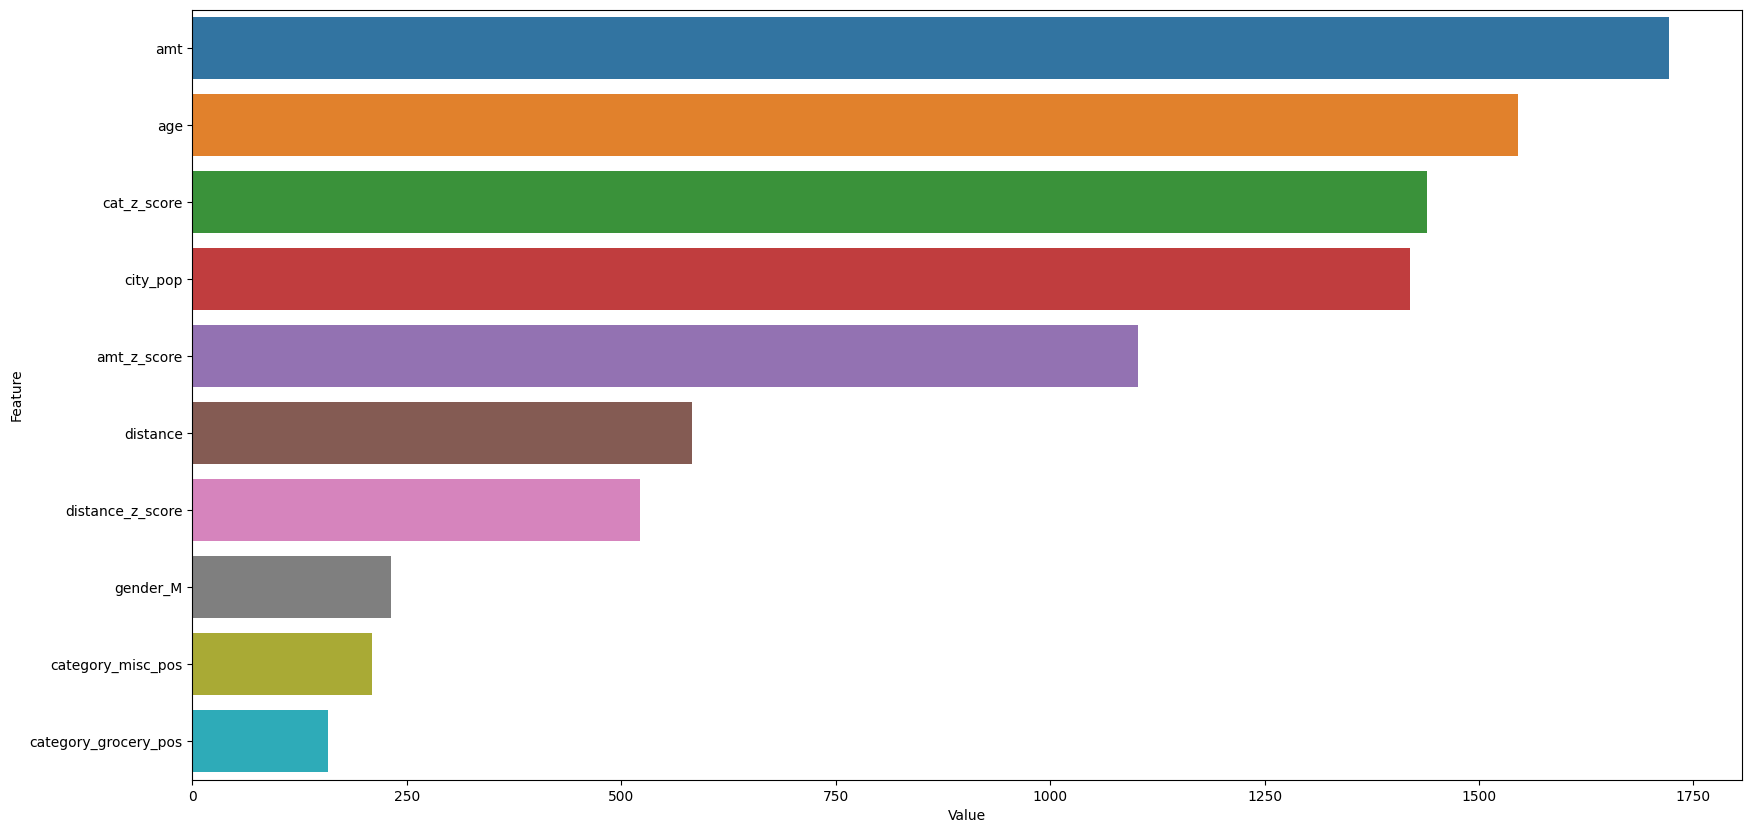

In [ ]:
# 모델 version_3 영향을 주는 feature 중요도

feature_imp3= pd.DataFrame(sorted(zip(md3.feature_importance(), X_train.columns), reverse= True), columns= ['Value', 'Feature'])

plt.figure(figsize= (20, 10))
sns.barplot(x= 'Value', y= 'Feature', data= feature_imp3.head(10))
plt.show()